## Script complementario para mejorar figuras y outputs usados para el reporte y la presentación
### Proyecto: Predicción de lluvia a una hora
#### Introducción a la Ciencia de Datos
#### Vladimir Garcia Loginova

La funcion del script solo es mejorar las figuras y output, solo se dejó lo necesario del script principal, pero se borraron muchas lineas y markdowns para poder modificarlo con mayor rapidez. El objetivo de mostrar este script es solo ilustrativo (ya que no esta comentado), para mostrar de donde salieron algunas de las figuras y outputs utilizados para el reporte, presentación y video.

In [1]:
# importe de pauqterías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score,recall_score,confusion_matrix
import random
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import time
import os
from sklearn.metrics import classification_report
#se define path
path=os.getcwd()

#### Lectura del dataset

In [2]:
df=pd.read_csv("rain_pembu3.csv")

Vemos que el dataset tiene un total de 2092068 registros y 16 atributos, donde el ultimo atributo ('Precip_sig_hora') corresponde a la variable obejetivo.

## Limpieza de datos

In [3]:

df.Fecha_hora=pd.to_datetime(df.Fecha_hora)

def avg_last_2_hours(df_group, columns):
    df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
    df_group['Fecha_hora'] = pd.to_datetime(df_group['Fecha_hora'])  # Asegurar que es de tipo datetime
    df_group = df_group.set_index('Fecha_hora')  # Establecer como índice
    for col in columns:
        avg_col_name = f'{col}_2h_mean'
        df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
    df_group = df_group.reset_index()

    return df_group
columns_to_average = ['Hum_Rel', 'Rapidez_v_sostenido', 'Rapidez_rachas']

df0 = df.groupby('Estacion').apply(lambda x: avg_last_2_hours(x, columns_to_average)).reset_index(drop=True)
df0 = df0.dropna(subset=[f'{col}_2h_mean' for col in columns_to_average])
df0=df0.rename(columns={"Rapidez_v_sostenido_2h_mean": "Rap_v_sos_2h_mean", "Rapidez_rachas_2h_mean": "Rap_rachas_2h_mean"})
print(df0.shape)

/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2557486623.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2557486623.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2557486623.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2557486623.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('

(2193267, 19)


#### Se mejoró output

In [4]:
cols=df.columns.values[5:]
#print(cols)
print(f"{'Variable':<22}{'# nan':<12}{'% nan':<12}")
for col in cols:
    num_nan=df[col].isna().sum()
    perc_data=(df[col].isna().sum()/df.shape[0])*100
    print(f"{col:<22}{num_nan:<12}{perc_data:<12.2f}")
print("")
print("No. de registros en dataset:",df.shape[0])


Variable              # nan       % nan       
Temp                  543526      20.48       
Hum_Rel               509398      19.20       
Rapidez_v_sostenido   438531      16.53       
Dir_v_sostenido       735766      27.73       
Rapidez_rachas        439468      16.56       
Dir_rachas            752765      28.37       
Presion_bar           472909      17.82       
Precipitacion         436596      16.45       
Rad_Solar             576072      21.71       
Indice_UV             567173      21.37       
Precip_sig_hora       437043      16.47       

No. de registros en dataset: 2653509


Ahora si eliminamos registros nan de las principales variables, que son : Temperatura, humedad relativa, precipitaicon y la variable objetivo precip_sig_hora

In [5]:
df1 = df0.dropna(subset=['Temp', 'Hum_Rel', 'Precipitacion','Precip_sig_hora']).copy()
print(df0.shape, df1.shape)

(2193267, 19) (2087830, 19)


Creamos variables de año, mes y hora para hacer más análisis de limpieza de datos

In [6]:
df1["Año"]=df1.Fecha_hora.dt.year
df1["Mes"]=df1.Fecha_hora.dt.month
df1["Hora"]=df1.Fecha_hora.dt.hour


Eliminamos posibles meses donde por alguna razon no se haya registrado lluvia en ningún día. Para ello primero revisamos por cada estacion año y mes si la suma de la precipitación es igual a cero.

#### Se mejoró output

In [7]:
dfp= df1.groupby(['Estacion','Año','Mes'])['Precipitacion'].sum()
to_drop = [(estacion, año, mes) for (estacion, año, mes), precipitacion in dfp.items() if precipitacion ==0]
# Filtro para quitar precipitaciones nula o ínfima
df2 = df1[~df1.set_index(['Estacion', 'Año', 'Mes']).index.isin(to_drop)]

print(f"{'Est':<6}{'Año':<6}{'Mes':<4}{'Prec':<4}")
suma=0
for (estacion,año, mes), precipitacion in dfp.items():
    if precipitacion == 0:
        suma+=1
        if suma >34:
            print(f"{estacion:<6}{año:<6}{mes:<4}{precipitacion:<4.2f}")

Est   Año   Mes Prec
CCHV  2021  8   0.00
CCHV  2021  10  0.00
CCHV  2022  5   0.00
CCHV  2022  6   0.00
CCHV  2022  7   0.00
ENP1  2003  8   0.00
ENP1  2011  7   0.00
ENP1  2011  9   0.00
ENP1  2013  7   0.00
ENP1  2017  7   0.00
ENP1  2020  8   0.00
ENP1  2020  9   0.00
ENP2  2005  6   0.00
ENP2  2010  10  0.00
ENP2  2014  7   0.00
ENP2  2017  10  0.00
ENP3  2003  5   0.00
ENP3  2006  6   0.00
ENP3  2006  8   0.00
ENP3  2011  5   0.00
ENP3  2011  6   0.00
ENP3  2011  7   0.00
ENP3  2011  8   0.00
ENP3  2022  6   0.00
ENP5  2020  7   0.00
ENP5  2021  6   0.00
ENP5  2021  7   0.00
ENP5  2021  8   0.00
ENP5  2023  5   0.00
ENP6  2005  9   0.00
ENP6  2005  10  0.00
ENP6  2006  9   0.00
ENP6  2008  5   0.00
ENP6  2008  10  0.00
ENP6  2010  6   0.00
ENP6  2012  7   0.00
ENP6  2012  8   0.00
ENP6  2012  9   0.00
ENP6  2012  10  0.00
ENP6  2014  7   0.00
ENP6  2014  9   0.00
ENP6  2014  10  0.00
ENP6  2020  8   0.00
ENP6  2020  10  0.00
ENP6  2021  6   0.00
ENP6  2021  8   0.00
ENP7  2003  5

Vemos que si hay muchas estaciones que en varios meses de distintos años  no tienen registros de lluvia, posiblemente por errores de medición o mal procesamiento de los datos. Procedemos a quitar estos registros, ya que generan mucho ruido para la clasificacion.

In [8]:
dfm=df2.groupby(["Hora"])[['Temp','Hum_Rel','Precipitacion','Rapidez_v_sostenido','Rapidez_rachas']].mean().reset_index()

Vemos que hay un patrón horario en cada variable y procedemos a graficar unas con otras respecto a la hora del día.

#### Se mejoró gráfica

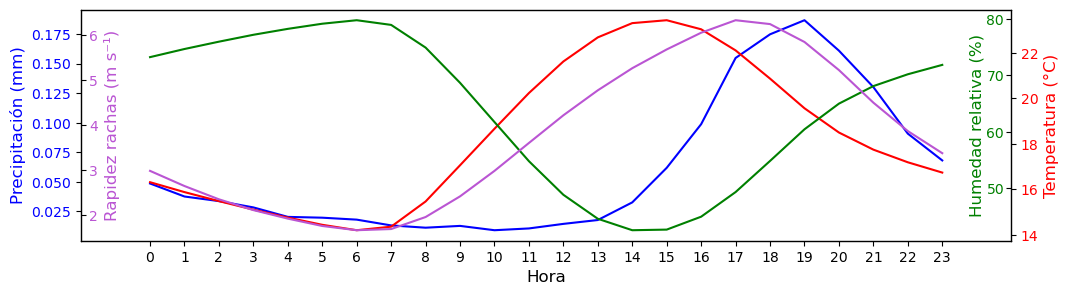

In [9]:

var_plots=['Precipitacion','Temp','Hum_Rel','Rapidez_rachas']
names=['Precipitación','Temperatura','Humedad relativa','Rapidez rachas']
color=['blue','red','green','mediumorchid']
units=['mm','°C','%','m s⁻¹']
#ab=['a','b']

fig=plt.figure(figsize=(12,3))
#for i in range(len(var_plots)):

ax=plt.gca()
ax.plot(dfm.Hora, dfm[var_plots[0]], color=color[0],label=names[0]+"(%s)"%units[0])
ax.set_ylabel(names[0]+" (%s)"%units[0],color=color[0],fontsize=12)
ax.tick_params(axis="y", labelcolor=color[0],labelsize=10)
ax2 = ax.twinx()
ax2.plot(dfm.Hora, dfm[var_plots[1]], color=color[1],label=names[1]+"(%s)"%units[1])
ax2.set_ylabel(names[1]+" (%s)"%units[1],color=color[1],fontsize=12)
ax2.tick_params(axis='y', labelcolor=color[1],labelsize=10)
ax3 = ax.twinx()
ax3.plot(dfm.Hora, dfm[var_plots[2]], color=color[2],label=names[2]+"(%s)"%units[2])
ax3.tick_params(axis="y", labelcolor=color[2], direction="in", pad=-5,labelsize=10)
ax3.set_ylabel(names[2]+" (%s)"%units[2],color=color[2],labelpad=-30,fontsize=12)
plt.setp(ax3.get_yticklabels(), ha="right")
ax4 = ax.twinx()
ax4.yaxis.tick_left()
ax4.plot(dfm.Hora, dfm[var_plots[3]], color=color[3],label=names[3]+"(%s)"%units[3])
ax4.tick_params(axis="y", labelcolor=color[3], direction="in", pad=-12,labelsize=10)
ax4.set_ylabel(names[3]+" (%s)"%units[3],color=color[3],labelpad=-653,fontsize=12)

ax.set_xticks(dfm.Hora)
ax.set_xlabel("Hora",fontsize=12)
ax.tick_params(axis="x",labelsize=10)
plt.xlim(-2,25)

plt.subplots_adjust(hspace=0.4)#hspace=0)
fig_name='figura_vars_prom_rain_no_rain_comp.png'
plt.savefig(path+'/figuras_comp/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
plt.show()
print("")


#### Se mejoró output

In [10]:
vars4=['Hora','Temp','Hum_Rel','Rapidez_rachas']#,'Rapidez_v_sostenido'
name_vars=['Temperatura', 'Humedad relativa','Rapidez rachas']
units2=['°C','%','m s⁻¹']
df_no_rain_vars=df2.loc[df2['Precipitacion'] == 0,vars4]
df_si_rain_vars=df2.loc[df2['Precipitacion'] >  0,vars4]
print(f"{'Variable':<25}{'No lluvia':<12}{'Lluvia':<8}")
for idx,var in enumerate(vars4[1:]):
    mean_no_rain=df_no_rain_vars.loc[:,var].mean().round(2)
    mean_si_rain=df_si_rain_vars.loc[:,var].mean().round(2)
    print(f"{name_vars[idx]+' (%s)'%units2[idx]:<25}{mean_no_rain:<12}{mean_si_rain:<8}")


Variable                 No lluvia   Lluvia  
Temperatura (°C)         18.43       15.9    
Humedad relativa (%)     63.05       84.25   
Rapidez rachas (m s⁻¹)   3.71        4.32    


## Clasificación don dataset de prueba

Para ver lso resultados finales, escogemos los tres mejores modelo de SL y la ANN para predecir si va a llover en la siguiente hora con el dataset de entrenamiento, al cual se le hacen los mismos procesos que al dataset de entrenamiento.

#### Se carga dataset de prueba

In [11]:
file_test="rain_pembu_test3.csv"
df_test=pd.read_csv(file_test)
print("columnas:",df.columns.values)
print(df_test.head(5),df_test.shape)

columnas: ['Estacion' 'Latitud' 'Longitud' 'Altitud' 'Fecha_hora' 'Temp' 'Hum_Rel'
 'Rapidez_v_sostenido' 'Dir_v_sostenido' 'Rapidez_rachas' 'Dir_rachas'
 'Presion_bar' 'Precipitacion' 'Rad_Solar' 'Indice_UV' 'Precip_sig_hora']
  Estacion  Latitud  Longitud  Altitud           Fecha_hora  Temp  Hum_Rel  \
0      CCA  19.3268  -99.1761     2277  2024-05-01 00:00:00  19.6     45.0   
1      CCA  19.3268  -99.1761     2277  2024-05-01 00:30:00  18.9     47.0   
2      CCA  19.3268  -99.1761     2277  2024-05-01 01:00:00  18.2     48.0   
3      CCA  19.3268  -99.1761     2277  2024-05-01 01:30:00  17.7     50.0   
4      CCA  19.3268  -99.1761     2277  2024-05-01 02:00:00  17.7     51.0   

   Rapidez_v_sostenido  Dir_v_sostenido  Rapidez_rachas  Dir_rachas  \
0                  0.0            292.5             0.9       292.5   
1                  0.0            292.5             0.4       292.5   
2                  0.0            292.5             0.4       292.5   
3                  

#### Se hace una limpieza de datos como la del entrenamiento, obteniendo antes la variable de Hum_Rel_ant2h_mean

In [12]:

df_test.Fecha_hora=pd.to_datetime(df_test.Fecha_hora)

def avg_last_2_hours(df_group, columns):
    df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
    df_group['Fecha_hora'] = pd.to_datetime(df_group['Fecha_hora'])  
    df_group = df_group.set_index('Fecha_hora')  
    for col in columns:
        avg_col_name = f'{col}_2h_mean'
        df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()

    df_group = df_group.reset_index()

    return df_group

columns_to_average = ['Hum_Rel', 'Rapidez_v_sostenido', 'Rapidez_rachas']

df_test0 = df_test.groupby('Estacion').apply(lambda x: avg_last_2_hours(x, columns_to_average)).reset_index(drop=True)

df_test0 = df_test0.dropna(subset=[f'{col}_2h_mean' for col in columns_to_average])
df_test0=df_test0.rename(columns={"Rapidez_v_sostenido_2h_mean": "Rap_v_sos_2h_mean", "Rapidez_rachas_2h_mean": "Rap_rachas_2h_mean"})

print(df0.shape)

(2193267, 19)


/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2716117588.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2716117588.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2716117588.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('2H', closed='right').mean()
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/2716117588.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_group[avg_col_name] = df_group[col].rolling('

In [13]:
df_test0=df_test0.drop(columns=['Presion_bar'])

In [14]:
df_test1 = df_test0.dropna(subset=['Temp', 'Hum_Rel', 'Precipitacion','Precip_sig_hora']).copy()
print(df_test1.shape)

(101948, 18)


### Se prepara dataset de prueba con el mismo aumento de características que en el dataset de entrenamiento

Se hace el mismo aumento de datos que en el dataset de prueba

In [15]:

df_test1["Año"]=df_test1.Fecha_hora.dt.year
df_test1["Mes"]=df_test1.Fecha_hora.dt.month
df_test1["Hora"]=df_test1.Fecha_hora.dt.hour
df_test1['Mañana_tarde'] = np.select([df_test1['Hora'] < 12, df_test1['Hora'] >= 12], [0,1])
df_test1["Precip_ahora"]=np.select([df_test1['Precipitacion'] > 0 ],[1],default=0)
df_test1['time_stamp'] = df_test1.Fecha_hora.values.astype(np.int64) // 10 ** 9

le = LabelEncoder()
st_num=le.fit_transform(df_test1.Estacion.values)
df_test2=df_test1.assign(Est_num=st_num)
print(df_test2.shape)

(101948, 25)


In [16]:
for i in range(1,3):
    def rain_prev_hour(df_group):
        df_group = df_group.sort_values('Fecha_hora').reset_index(drop=True)
        df_prev = df_group.copy()
        df_prev['Fecha_hora'] += pd.Timedelta(hours=i)  
    
        merged = pd.merge(df_group, df_prev[['Fecha_hora', 'Precipitacion']], 
                          on='Fecha_hora', suffixes=('', '_prev'), how='left')
        
        merged['Precip_ant_%shora'%(i)] = (merged['Precipitacion_prev'] > 0).apply(lambda x: 1 if x > 0 else (0 if pd.notna(x) else pd.NA))
        
        return merged.drop(columns=['Precipitacion_prev'])
    
    df_test2 = df_test2.groupby(['Estacion',pd.PeriodIndex(df_test2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)

df_test3 = df_test2.dropna(subset=['Precip_ant_1hora','Precip_ant_2hora'])
print(df_test3.shape)

/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/157615746.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test2 = df_test2.groupby(['Estacion',pd.PeriodIndex(df_test2['Fecha_hora'], freq="Y")]).apply(rain_prev_hour).reset_index(drop=True)
/var/folders/fw/lfwqgrwx72v8gqhx3vm2nv780000gn/T/ipykernel_2437/157615746.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test2 = df_test2.

(101948, 27)


Se tiran datos nan

In [17]:
df_test3=df_test3.dropna().reset_index(drop=True)
print(df_test3.shape)

(95635, 27)


#### Se mejoró gráfica

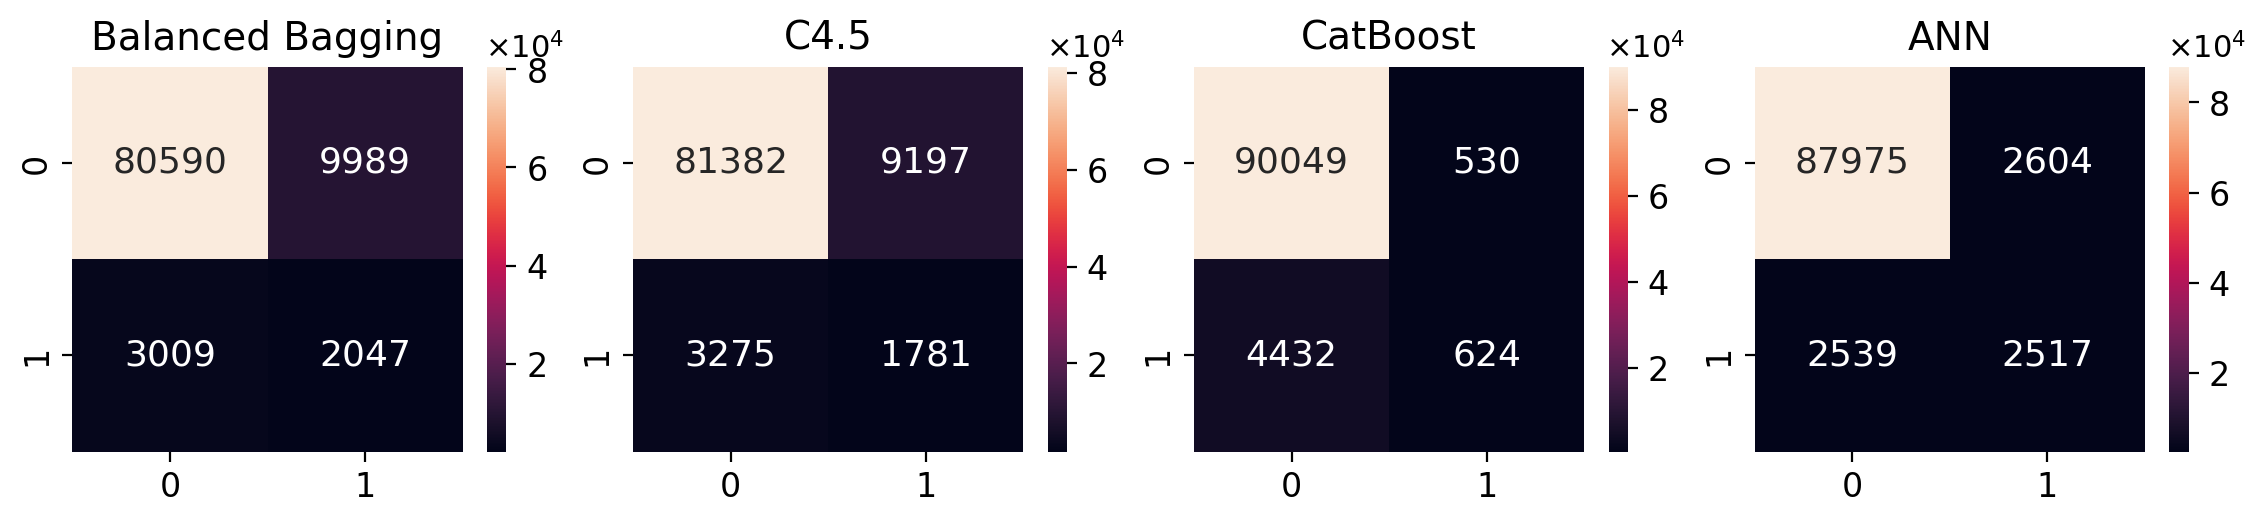

In [18]:
import matplotlib.ticker as tkr

formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
models_name_m=['Balanced Bagging','C4.5','CatBoost','ANN']

file_res="y_predict_test_models.csv"
path_res=os.getcwd()+'/results/'
df_res=pd.read_csv(path_res+file_res)
cm_test=[]
y_test_m=df_res.y_test2.values
fig = plt.figure(figsize=(14,2.5),dpi=200)
for idx,col in enumerate(df_res.columns.values[:-1]):
    y_pred_m=df_res.loc[:,col].values
    cm= confusion_matrix(y_test_m,y_pred_m)
    plt.subplot(1,4,idx+1)
    ax=sns.heatmap(cm, annot=True,annot_kws={"size":13},cbar_kws={"format": formatter,},fmt='.0f')
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    offset_text = cbar.ax.yaxis.get_offset_text()
    offset_text.set_x(4)  # Ajusta la posición horizontal del texto
    offset_text.set_y(1.05)
    offset_text.set_fontsize(11)
    plt.title(models_name_m[idx],fontsize=14)
    
plt.subplots_adjust(wspace=0.15,hspace=0.01)
fig_name='figura_cm_test_comp.png'
plt.savefig(path+'/figuras_comp/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')

In [19]:
print(df_res)

       Balanced Bagging  C4.5  CatBoost  ANN  y_test2
0                   0.0   0.0       0.0  0.0      0.0
1                   0.0   0.0       0.0  0.0      0.0
2                   0.0   0.0       0.0  0.0      0.0
3                   0.0   0.0       0.0  0.0      0.0
4                   0.0   0.0       0.0  0.0      0.0
...                 ...   ...       ...  ...      ...
95630               0.0   0.0       0.0  0.0      0.0
95631               0.0   0.0       0.0  0.0      0.0
95632               0.0   0.0       0.0  0.0      0.0
95633               0.0   0.0       0.0  0.0      0.0
95634               0.0   0.0       0.0  0.0      0.0

[95635 rows x 5 columns]


#### Se mejoró gráfica

Predicción en ENP6 del 20 al 23 de septiembre del 2024


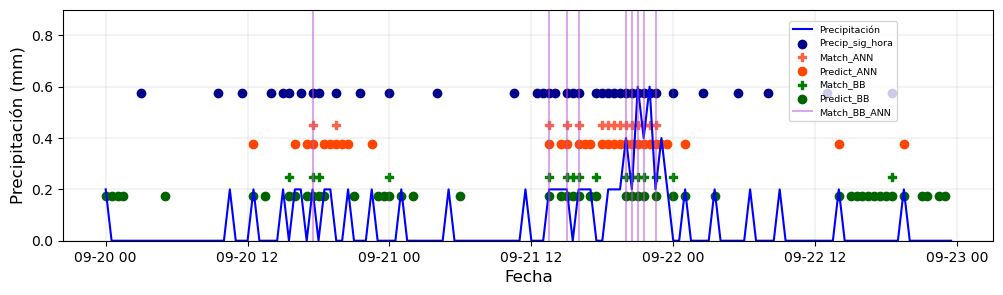

Predicción en ENP9 del 25 al 28 de junio del 2024


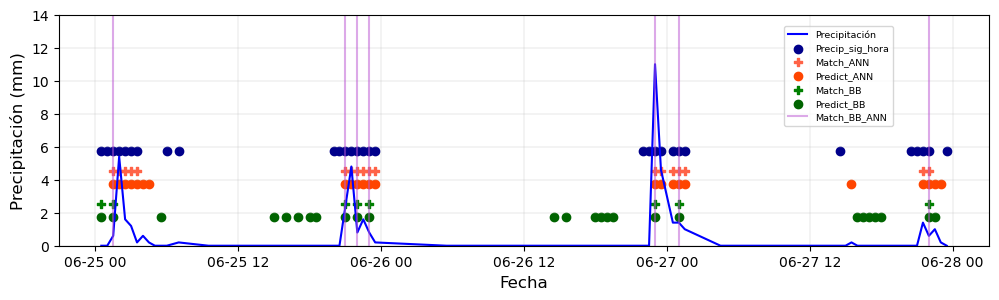

In [20]:
#variables pa usar en la graficacion
dia=[[19,23],[24,28]]
mes=[9,6]
est=['ENP6','ENP9']
pos=[1,10]
meses=['enero','febrero','marzo','abril','mayo','junio','julio',\
      'agosto','septiembre','octubre','noviembre','diciembre']
models_p=['BB','ANN']
colors=[['darkgreen','green'],['orangered','tomato']]
ab=['a','b']


for i in range(len(est[:2])):
    #i=i+1
    # se eligen las estaciones y periodos de interes
    var=df_test3.loc[(df_test3.Estacion==est[i]) & (df_test3.Mes == mes[i]) &\
(df_test3.Fecha_hora.dt.day>dia[i][0]) & (df_test3.Fecha_hora.dt.day<dia[i][1]),\
['Fecha_hora','Precip_sig_hora','Precipitacion']]
    
    index_var=var.index.values
    #variable objetivo
    p=var.Precip_sig_hora.values
    p2= np.where(p == 0, np.nan, np.where(p == 1, 0.575*pos[i], p))
    #prediccion balanced bagging
    pb=df_res['Balanced Bagging'][index_var]
    pb2=np.where(pb == 0, np.nan, np.where(pb == 1, 0.175 *pos[i], pb))
    #prediccion ANN
    pt=df_res['ANN'][index_var]
    pt2=np.where(pt == 0, np.nan, np.where(pt == 1, 0.375 *pos[i], pt))

    #indices donde hizo match la predicción con la variable objetivo
    match_sl=np.where((p == 1) & (pb == 1), 0.25 * pos[i], np.nan)
    match_ann=np.where((p == 1) & (pt == 1), 0.45 * pos[i], np.nan)

    match_sl_ann=np.where((p == 1) & (pb == 1) & (pt==1), max(var.Precipitacion.values)+(0.3*pos[i]), np.nan)
    mask_match=~np.isnan(match_sl_ann)

    vals=[[pb2,match_sl],[pt2,match_ann]]

    # se crean graficas
    fig = plt.figure(figsize=(12,3))
    #for j in range(2):
    #plt.subplot(2,1,j+1)
    ax=plt.gca()
    plt.plot(var.Fecha_hora,var.Precipitacion,color='blue',label="Precipitación")
    plt.scatter(var.Fecha_hora,p2,color='darkblue',label="Precip_sig_hora")
    plt.scatter(var.Fecha_hora,vals[1][1],color=colors[1][1],label="Match_%s"%models_p[1],marker='P')
    plt.scatter(var.Fecha_hora,vals[1][0],color=colors[1][0],label="Predict_%s"%models_p[1])        
    plt.scatter(var.Fecha_hora,vals[0][1],color=colors[0][1],label="Match_%s"%models_p[0],marker='P')
    plt.scatter(var.Fecha_hora,vals[0][0],color=colors[0][0],label="Predict_%s"%models_p[0]) 
    for idk,k in enumerate(var.Fecha_hora.values[mask_match]):
        if idk == 0:
            plt.axvline(k, color='mediumorchid', alpha=0.5, label='Match_BB_ANN')
        else:
             plt.axvline(k, color='mediumorchid',alpha=0.5,)
        
    plt.legend(loc=(0.78,0.52),fontsize=6.85)
    plt.xlabel("Fecha",fontsize=12)
    plt.ylabel("Precipitación (mm)",fontsize=12)
    plt.ylim(0,max(var.Precipitacion.values)+(0.3*pos[i]))
    plt.grid(True,lw=0.2)

    plt.subplots_adjust(hspace=0.3)#hspace=0)
    print('Predicción en %s del %s al %s de %s del 2024' %(est[i],dia[i][0]+1,dia[i][1],meses[mes[i]-1]))

    fig_name='figura_predict_comp%s.png'%(est[i])
    plt.savefig(path+'/figuras_comp/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
    plt.show()

Predicción de si-lluvia en ENP6 del 20 al 23 de septiembre del 2024


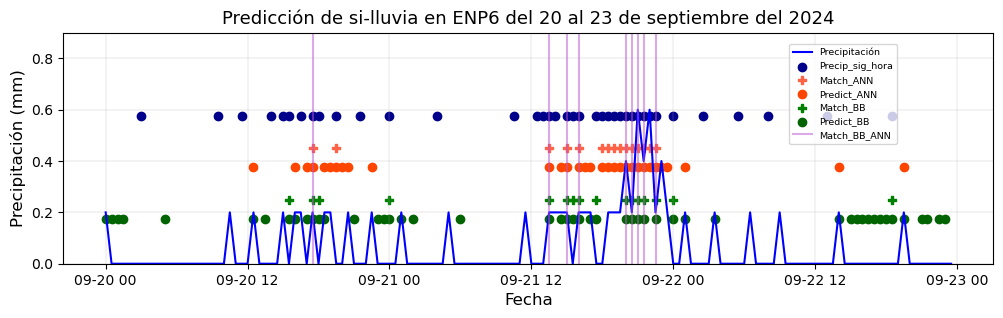

Predicción de si-lluvia en ENP9 del 25 al 28 de junio del 2024


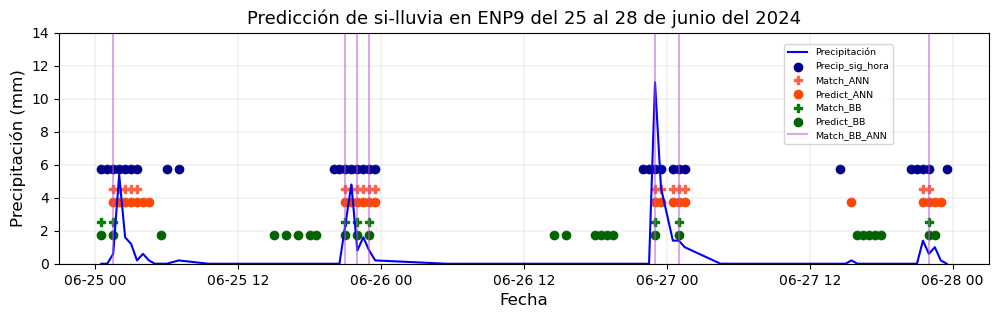

In [21]:
#variables pa usar en la graficacion
dia=[[19,23],[24,28]]
mes=[9,6]
est=['ENP6','ENP9']
pos=[1,10]
meses=['enero','febrero','marzo','abril','mayo','junio','julio',\
      'agosto','septiembre','octubre','noviembre','diciembre']
models_p=['BB','ANN']
colors=[['darkgreen','green'],['orangered','tomato']]
ab=['a','b']


for i in range(len(est[:2])):
    #i=i+1
    # se eligen las estaciones y periodos de interes
    var=df_test3.loc[(df_test3.Estacion==est[i]) & (df_test3.Mes == mes[i]) &\
(df_test3.Fecha_hora.dt.day>dia[i][0]) & (df_test3.Fecha_hora.dt.day<dia[i][1]),\
['Fecha_hora','Precip_sig_hora','Precipitacion']]
    
    index_var=var.index.values
    #variable objetivo
    p=var.Precip_sig_hora.values
    p2= np.where(p == 0, np.nan, np.where(p == 1, 0.575*pos[i], p))
    #prediccion balanced bagging
    pb=df_res['Balanced Bagging'][index_var]
    pb2=np.where(pb == 0, np.nan, np.where(pb == 1, 0.175 *pos[i], pb))
    #prediccion ANN
    pt=df_res['ANN'][index_var]
    pt2=np.where(pt == 0, np.nan, np.where(pt == 1, 0.375 *pos[i], pt))

    #indices donde hizo match la predicción con la variable objetivo
    match_sl=np.where((p == 1) & (pb == 1), 0.25 * pos[i], np.nan)
    match_ann=np.where((p == 1) & (pt == 1), 0.45 * pos[i], np.nan)

    match_sl_ann=np.where((p == 1) & (pb == 1) & (pt==1), max(var.Precipitacion.values)+(0.3*pos[i]), np.nan)
    mask_match=~np.isnan(match_sl_ann)

    vals=[[pb2,match_sl],[pt2,match_ann]]

    # se crean graficas
    fig = plt.figure(figsize=(12,3))
    #for j in range(2):
    #plt.subplot(2,1,j+1)
    ax=plt.gca()
    plt.plot(var.Fecha_hora,var.Precipitacion,color='blue',label="Precipitación")
    plt.scatter(var.Fecha_hora,p2,color='darkblue',label="Precip_sig_hora")
    plt.scatter(var.Fecha_hora,vals[1][1],color=colors[1][1],label="Match_%s"%models_p[1],marker='P')
    plt.scatter(var.Fecha_hora,vals[1][0],color=colors[1][0],label="Predict_%s"%models_p[1])        
    plt.scatter(var.Fecha_hora,vals[0][1],color=colors[0][1],label="Match_%s"%models_p[0],marker='P')
    plt.scatter(var.Fecha_hora,vals[0][0],color=colors[0][0],label="Predict_%s"%models_p[0]) 
    for idk,k in enumerate(var.Fecha_hora.values[mask_match]):
        if idk == 0:
            plt.axvline(k, color='mediumorchid', alpha=0.5, label='Match_BB_ANN')
        else:
             plt.axvline(k, color='mediumorchid',alpha=0.5,)
        
    plt.legend(loc=(0.78,0.52),fontsize=6.85)
    plt.xlabel("Fecha",fontsize=12)
    plt.ylabel("Precipitación (mm)",fontsize=12)
    plt.ylim(0,max(var.Precipitacion.values)+(0.3*pos[i]))
    plt.grid(True,lw=0.2)
    plt.title('Predicción de si-lluvia en %s del %s al %s de %s del 2024'\
              %(est[i],dia[i][0]+1,dia[i][1],meses[mes[i]-1]),fontsize=13)

    plt.subplots_adjust(hspace=0.3)#hspace=0)
    
    print('Predicción de si-lluvia en %s del %s al %s de %s del 2024' %(est[i],dia[i][0]+1,dia[i][1],meses[mes[i]-1]))
    fig_name='figura_predict_comp%s_2.png'%(est[i])
    plt.savefig(path+'/figuras_comp/%s'%fig_name,dpi=300,facecolor='white',bbox_inches='tight')
    plt.show()